<a href="https://colab.research.google.com/github/Bangkit-Capstone-C241-BB01/BlurOrBokeh_ML_All/blob/main/Salinan_dari_Transfer_Learning_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning Approach

## Setup

In [ ]:
import os
import sys
import PIL
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

PIL.Image.MAX_IMAGE_PIXELS = None

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
base_dir = "/content/drive/My Drive/Blur or Bokeh"

data_dir = os.path.join(base_dir, "Dataset")
library_dir = os.path.join(base_dir, "Library")
serialized_data_dir = os.path.join(base_dir, "Serialized Data")
braincore_data_dir = os.path.join(data_dir, "Braincore")

sys.path.append(library_dir)
from cf_matrix import make_confusion_matrix

## Load the Dataset

In [ ]:
image_size = (150, 150)
class_names = ["Blur", "Bokeh", "Normal"]

train_dir = os.path.join(braincore_data_dir, "train")
validation_dir = os.path.join(braincore_data_dir, "val")
test_dir = os.path.join(braincore_data_dir, "test")
combined_train_data_dir = os.path.join(data_dir, "Combined Training Data")


combine_train_data = False

if combine_train_data:
    import shutil

    scraped_data_dir = os.path.join(data_dir, "Scraped")
    kaggle_data_dir = os.path.join(data_dir, "Kaggle")
    train_data_dirs = [train_dir, scraped_data_dir, kaggle_data_dir]

    for train_data_dir in train_data_dirs:
        classes = os.listdir(train_data_dir)
        for cls in classes:
            cls_dir = os.path.join(train_data_dir, cls)
            combined_cls_dir = os.path.join(combined_train_data_dir, cls)
            if not os.path.exists(combined_cls_dir):
                os.makedirs(combined_cls_dir)
            for file in os.listdir(cls_dir):
                shutil.copy(os.path.join(cls_dir, file), combined_cls_dir)

train_dir = combined_train_data_dir

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=32,
    class_mode="sparse"
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=32,
    class_mode="sparse"
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=2000,
    class_mode="sparse",
    shuffle=False
)

Found 2910 images belonging to 3 classes.
Found 328 images belonging to 3 classes.
Found 114 images belonging to 3 classes.


## Build the Model

In [ ]:
pre_trained_model = InceptionV3(
    input_shape=image_size + (3,),
    include_top=False,
    weights="imagenet"
)
pre_trained_model.trainable = True

87910968/87910968 [==============================] - 3s 0us/step


In [ ]:
last_layer = pre_trained_model.get_layer("mixed1")
last_layer = last_layer.output

x = tf.keras.layers.BatchNormalization()(last_layer)
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x)
x = Dense(32, activation="relu")(x)
x = Dense(3, activation="softmax")(x)

model = Model(pre_trained_model.input, x)
model.compile(optimizer=Adam(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalization[0][0

## Train, Evaluate, and Save the Model

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=60
)

Epoch 1/60
90/90 [==============================] - 1452s 16s/step - loss: 0.6426 - accuracy: 0.7373 - val_loss: 0.5845 - val_accuracy: 0.7750
Epoch 2/60
90/90 [==============================] - 73s 807ms/step - loss: 0.4130 - accuracy: 0.8356 - val_loss: 0.3534 - val_accuracy: 0.8781
Epoch 3/60
90/90 [==============================] - 72s 798ms/step - loss: 0.3734 - accuracy: 0.8614 - val_loss: 0.4495 - val_accuracy: 0.8344
Epoch 4/60
90/90 [==============================] - 72s 795ms/step - loss: 0.3146 - accuracy: 0.8850 - val_loss: 0.4562 - val_accuracy: 0.8375
Epoch 5/60
90/90 [==============================] - 71s 796ms/step - loss: 0.2931 - accuracy: 0.8881 - val_loss: 0.4192 - val_accuracy: 0.8531
Epoch 6/60
90/90 [==============================] - 72s 800ms/step - loss: 0.2896 - accuracy: 0.8885 - val_loss: 0.3235 - val_accuracy: 0.8750
Epoch 7/60
90/90 [==============================] - 71s 795ms/step - loss: 0.2609 - accuracy: 0.9006 - val_loss: 0.2736 - val_accuracy: 0.9125

In [ ]:
model_weights_filename = "Transfer Learning Model_60epochs_attempt.h5"

In [ ]:
model.save_weights(os.path.join(serialized_data_dir, model_weights_filename))

In [ ]:
model.load_weights(os.path.join(serialized_data_dir, model_weights_filename))

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

1/1 [==============================] - 3s 3s/step - loss: 0.8717 - accuracy: 0.8509
Test Accuracy: 0.8509


## Visualization

### Confusion Matrix

In [ ]:
X_test, y_test = next(test_generator)

4/4 [==============================] - 1s 243ms/step


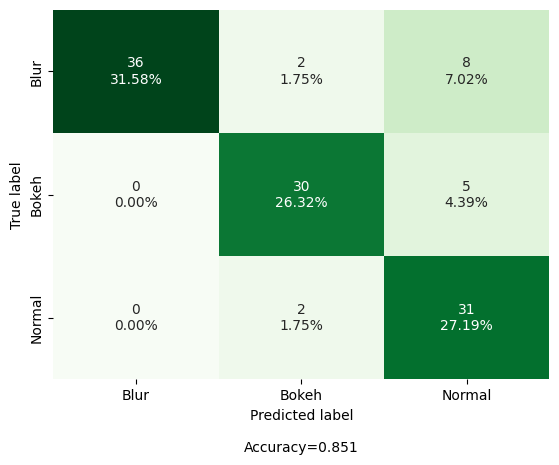

In [ ]:
test_pred = model.predict(X_test)
test_pred = tf.argmax(test_pred, axis=1)
cm = confusion_matrix(y_test, test_pred)
make_confusion_matrix(cm, categories=class_names, cmap="Greens", cbar=False)

### Error Analysis

In [ ]:
error_image = X_test[test_pred != y_test]
error_label = tf.cast(y_test[test_pred != y_test],tf.int32)
error_pred = test_pred[test_pred != y_test]

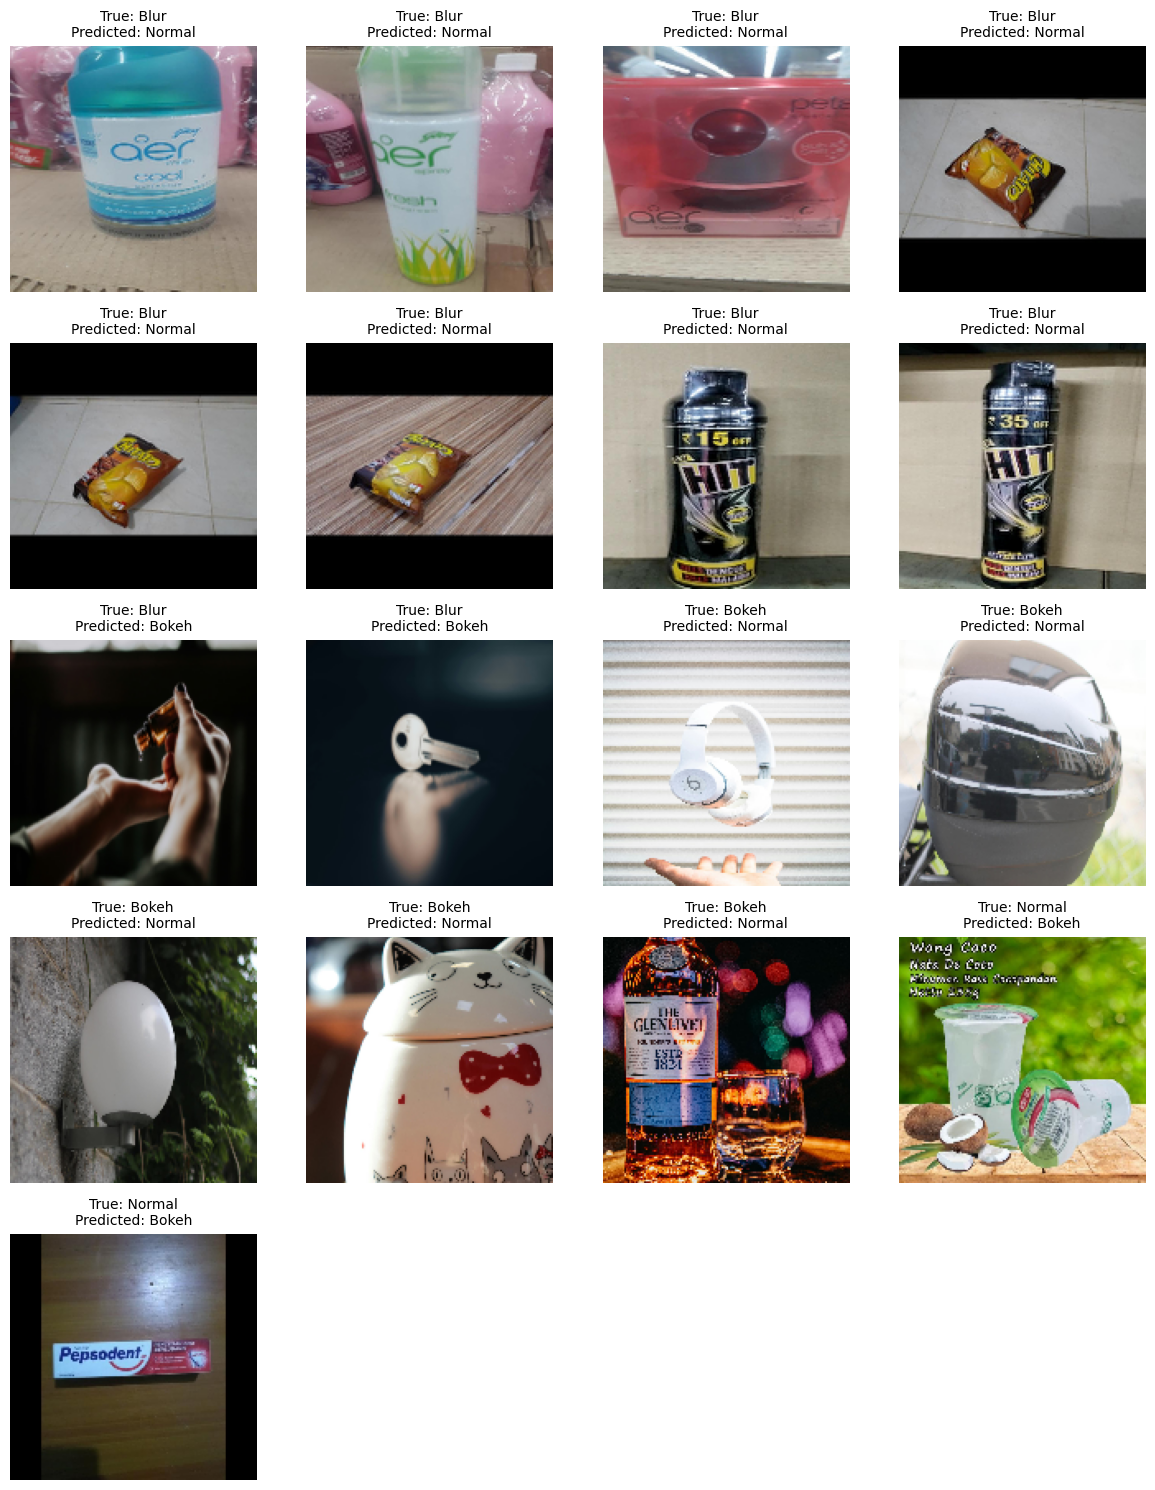

In [ ]:
num_row = 5
num_col = 4
subplot_size = 3
plt.figure(figsize=(num_col*subplot_size, num_row*subplot_size))
for i in range(len(error_image)):
    plt.subplot(num_row, num_col, i+1)
    plt.imshow(error_image[i])
    plt.axis("off")
    plt.title(f"True: {class_names[error_label[i]]}\nPredicted: {class_names[error_pred[i]]}", fontsize=10)
plt.tight_layout()
plt.show()

### Model Architecture

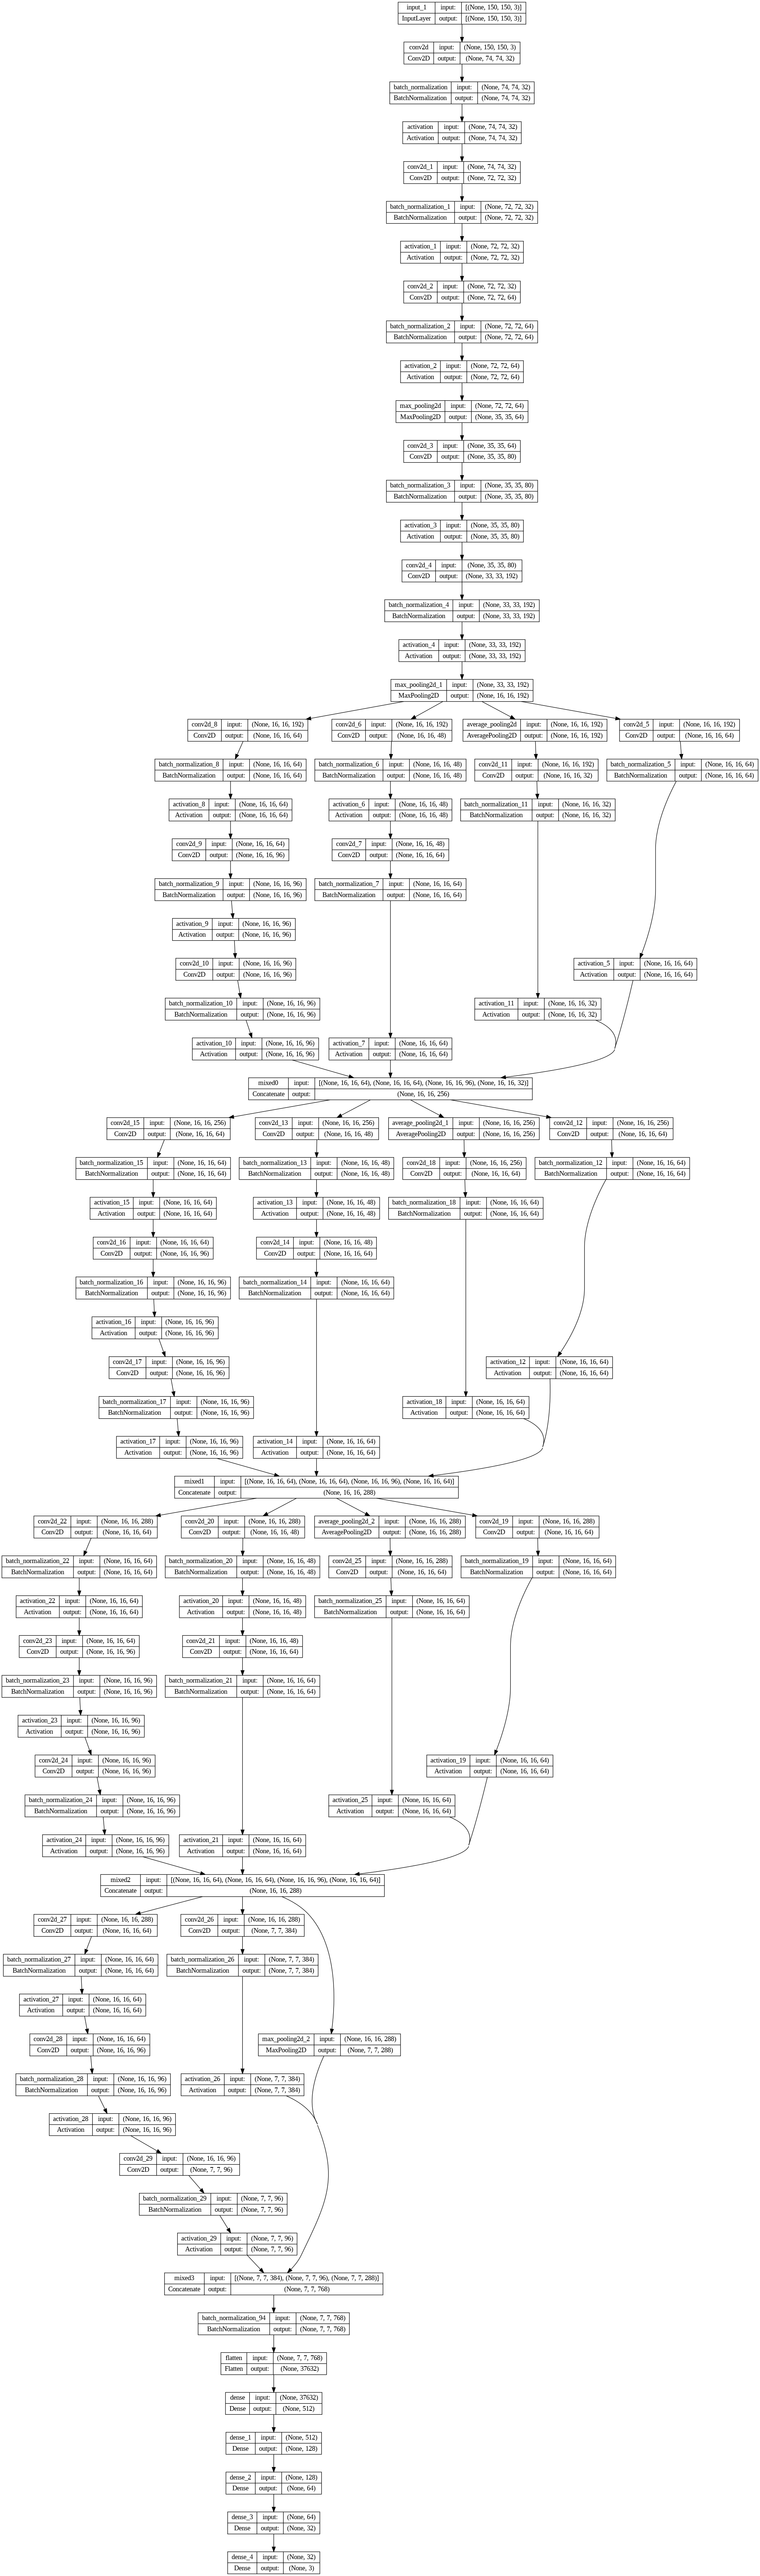

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)